In [3]:
#importing the libraries
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

RANDOM_STATE = 42


In [4]:
#loading the dataset
import pandas as pd

DATA_PATH = "../data/ml_input_full.csv"
df = pd.read_csv(DATA_PATH)

print("Loaded:", DATA_PATH)
print(df.shape)
df.head()


Loaded: ../data/ml_input_full.csv
(5986025, 46)


,ARREST_KEY,ARREST_DATE,arrest_date_day,Year,Month,Day,Hour,Weekday,WeekOfYear,Quarter,...,Longitude_scaled,total_arrests,felony_rate,violent_rate,daily_arrests,arrests_yesterday,arrests_last_7_days,arrests_7day_avg,arrests_30day_avg,basket_str
0,298672659,2024-12-31,2024-12-31,2024,12,31,0,1,1,4,...,0.001850,109910,0.351415,0.272186,449,591,3804,543.428571,654.5,"OFF_ASSAULT,BORO_S,PREC_120,AGE_18-24,SEX_M,RA..."
1,298692609,2024-12-31,2024-12-31,2024,12,31,0,1,1,4,...,0.004682,41067,0.346288,0.267904,449,591,3804,543.428571,654.5,"OFF_VEHICLE_AND_TRAFFIC_LAWS,BORO_K,PREC_63,AG..."
2,298692620,2024-12-31,2024-12-31,2024,12,31,0,1,1,4,...,0.003724,78123,0.247648,0.181227,449,591,3804,543.428571,654.5,"OFF_THEFT,BORO_M,PREC_13,AGE_25-44,SEX_F,RACE_..."
3,298685051,2024-12-31,2024-12-31,2024,12,31,0,1,1,4,...,0.003674,34144,0.242590,0.189872,449,591,3804,543.428571,654.5,"OFF_ROBBERY,BORO_M,PREC_20,AGE_45+,SEX_M,RACE_..."
4,298694799,2024-12-31,2024-12-31,2024,12,31,0,1,1,4,...,0.001622,34453,0.325922,0.241634,449,591,3804,543.428571,654.5,"OFF_DRUG,BORO_S,PREC_121,AGE_25-44,SEX_F,RACE_..."


In [5]:
#feature definitions

#target
TARGET = "felony_flag"  # 0/1

if TARGET not in df.columns:
    raise ValueError(f"Target column '{TARGET}' not found in dataframe columns: {df.columns.tolist()}")

#categorical features based on your sample schema
categorical_features = ["ARREST_BORO", "AGE_GROUP","PERP_SEX","perp_race_clean","offense_group",
]

#numeric features (time, geography, arrest dynamics)
numeric_features = [
    "Year", "Month","Day","Hour", "Weekday","WeekOfYear", "Quarter", "Is_Weekend", "Pre_Post_2020", "During_COVID_Lockdown",
    "Latitude", "Longitude", "total_arrests","felony_rate", "violent_rate", "daily_arrests", "arrests_yesterday", 
    "arrests_last_7_days","arrests_7day_avg","arrests_30day_avg",
]

#keeping only columns that actually exist
categorical_features = [c for c in categorical_features if c in df.columns]
numeric_features = [c for c in numeric_features if c in df.columns]

if not categorical_features:
    raise ValueError("No categorical_features found in dataframe. Check column names.")
if not numeric_features:
    raise ValueError("No numeric_features found in dataframe. Check column names.")

all_features = categorical_features + numeric_features

print("Using categorical features:", categorical_features)
print("Using numeric features:", numeric_features)

#dropping rows with missing values in features + target
df_model = df[all_features + [TARGET]].dropna()
print("Shape after dropping NA for modeling:", df_model.shape)

X = df_model[all_features]
y = df_model[TARGET].astype(int)


Using categorical features: ['ARREST_BORO', 'AGE_GROUP', 'PERP_SEX', 'perp_race_clean', 'offense_group']
Using numeric features: ['Year', 'Month', 'Day', 'Hour', 'Weekday', 'WeekOfYear', 'Quarter', 'Is_Weekend', 'Pre_Post_2020', 'During_COVID_Lockdown', 'Latitude', 'Longitude', 'total_arrests', 'felony_rate', 'violent_rate', 'daily_arrests', 'arrests_yesterday', 'arrests_last_7_days', 'arrests_7day_avg', 'arrests_30day_avg']
Shape after dropping NA for modeling: (5986025, 26)


In [6]:
#train test split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=RANDOM_STATE, stratify=y,
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Class distribution (train):")
print(y_train.value_counts(normalize=True))

Train shape: (4788820, 25) Test shape: (1197205, 25)
Class distribution (train):
felony_flag
0    0.704673
1    0.295327
Name: proportion, dtype: float64


In [7]:

#columnTransformers for different model types

#for Logistic Regression & SVM: One-Hot for cat + StandardScaler for numeric
preprocess_ohe = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", StandardScaler(), numeric_features),
    ]
)

#for RandomForest: Ordinal-encode categorical + pass numeric as is
# (RF doesn't need scaling; ordinal encoding is enough)
preprocess_ordinal = ColumnTransformer(
    transformers=[
        ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), categorical_features),
        ("num", "passthrough", numeric_features),
    ]
)


In [8]:
# logistic Regression

print("\n================ Logistic Regression ================\n")

log_reg_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess_ohe),
        (
            "clf",
            LogisticRegression(
                max_iter=1000,
                class_weight="balanced",  # helps if classes are imbalanced
                n_jobs=-1,
                solver="lbfgs",
            ),
        ),
    ]
)

log_reg_pipeline.fit(X_train, y_train)
y_pred_lr = log_reg_pipeline.predict(X_test)

print("Logistic Regression - Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nClassification Report (Logistic Regression):\n")
print(classification_report(y_test, y_pred_lr, digits=4))

# ROC-AUC (only if both classes present)
try:
    y_proba_lr = log_reg_pipeline.predict_proba(X_test)[:, 1]
    roc_auc_lr = roc_auc_score(y_test, y_proba_lr)
    print("ROC-AUC (Logistic Regression):", roc_auc_lr)
except Exception as e:
    print("Could not compute ROC-AUC for Logistic Regression:", e)



================ Logistic Regression ================

Logistic Regression - Accuracy: 0.7492835395775995

Classification Report (Logistic Regression):

              precision    recall  f1-score   support

           0     0.8622    0.7668    0.8117    843638
           1     0.5597    0.7076    0.6250    353567

    accuracy                         0.7493   1197205
   macro avg     0.7110    0.7372    0.7184   1197205
weighted avg     0.7729    0.7493    0.7566   1197205

ROC-AUC (Logistic Regression): 0.845031549569082


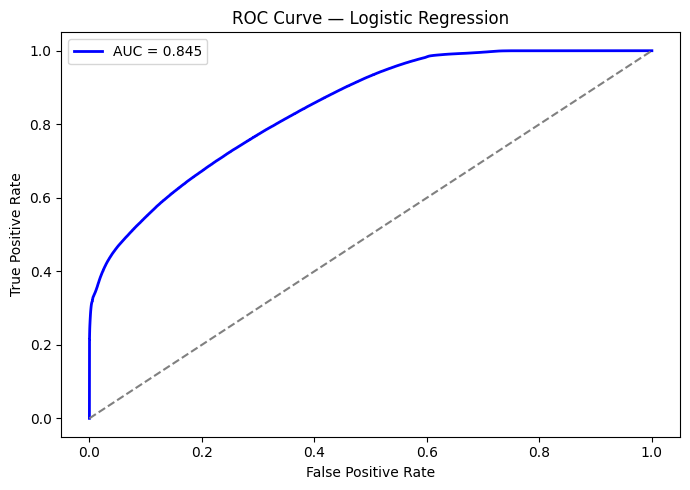

In [12]:
#roc curve 
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_proba_lr = log_reg_pipeline.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba_lr)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color="blue", linewidth=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.title("ROC Curve — Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()


Top 20 strongest LR coefficients:



/var/folders/4l/ps8gtn856617_4nt7nzqdfm80000gn/T/ipykernel_36995/1884714343.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


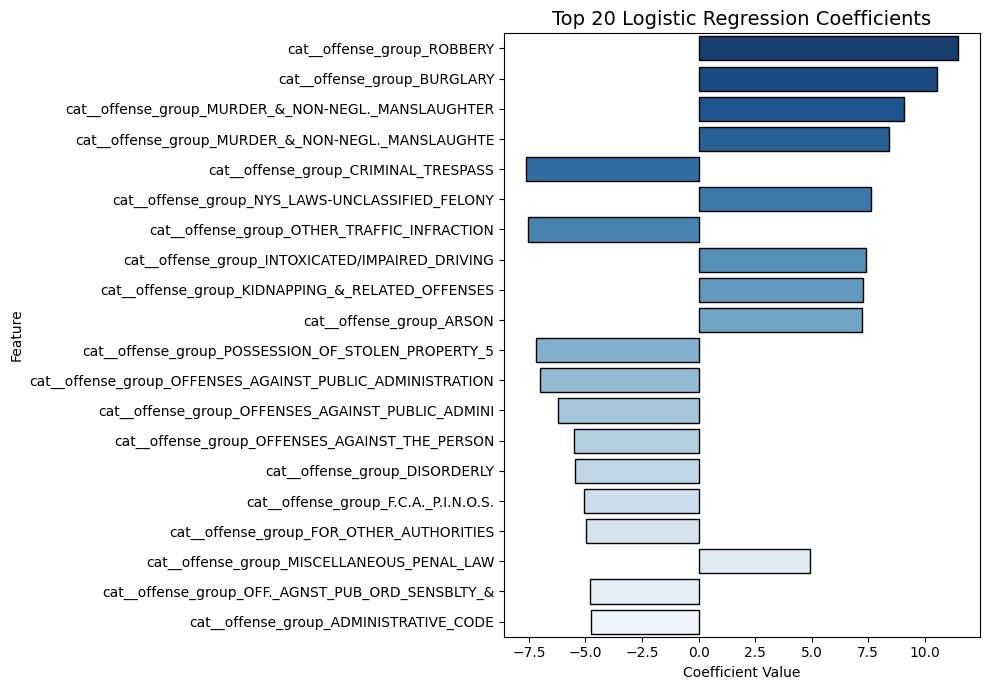

In [11]:
#logistic regression coefficients
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure model and scaler exist
# (logreg, X_train_scaled, X_train, etc.)
pre = log_reg_pipeline.named_steps["preprocess"]
lr_model = log_reg_pipeline.named_steps["clf"]

try:
    feature_names = pre.get_feature_names_out()
except:
    # fallback
    feature_names = X_train.columns

# LR coefficients (1D array)
coeffs = lr_model.coef_.flatten()

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coeffs
})
import numpy as np
import pandas as pd

pre = log_reg_pipeline.named_steps["preprocess"]
lr_model = log_reg_pipeline.named_steps["clf"]

try:
    feature_names = pre.get_feature_names_out()
except:
    # fallback
    feature_names = X_train.columns

# LR coefficients (1D array)
coeffs = lr_model.coef_.flatten()

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coeffs
})

# Sort by absolute strength
coef_df_sorted = coef_df.reindex(coef_df.coefficient.abs().sort_values(ascending=False).index)

print("\nTop 20 strongest LR coefficients:\n")
coef_df_sorted.head(20)


topN = 20
top_coef = coef_df_sorted.head(topN)

plt.figure(figsize=(10, 7))
sns.barplot(
    data=top_coef,
    y="feature",
    x="coefficient",
    palette="Blues_r",
    edgecolor="black"
)

plt.title("Top 20 Logistic Regression Coefficients", fontsize=14)
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()



================ RANDOM FOREST ================

Accuracy: 0.7122489465045669

Classification Report:

              precision    recall  f1-score   support

           0     0.8044    0.7818    0.7929    843638
           1     0.5120    0.5463    0.5286    353567

    accuracy                         0.7122   1197205
   macro avg     0.6582    0.6641    0.6608   1197205
weighted avg     0.7180    0.7122    0.7149   1197205



/var/folders/4l/ps8gtn856617_4nt7nzqdfm80000gn/T/ipykernel_34971/3941161953.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


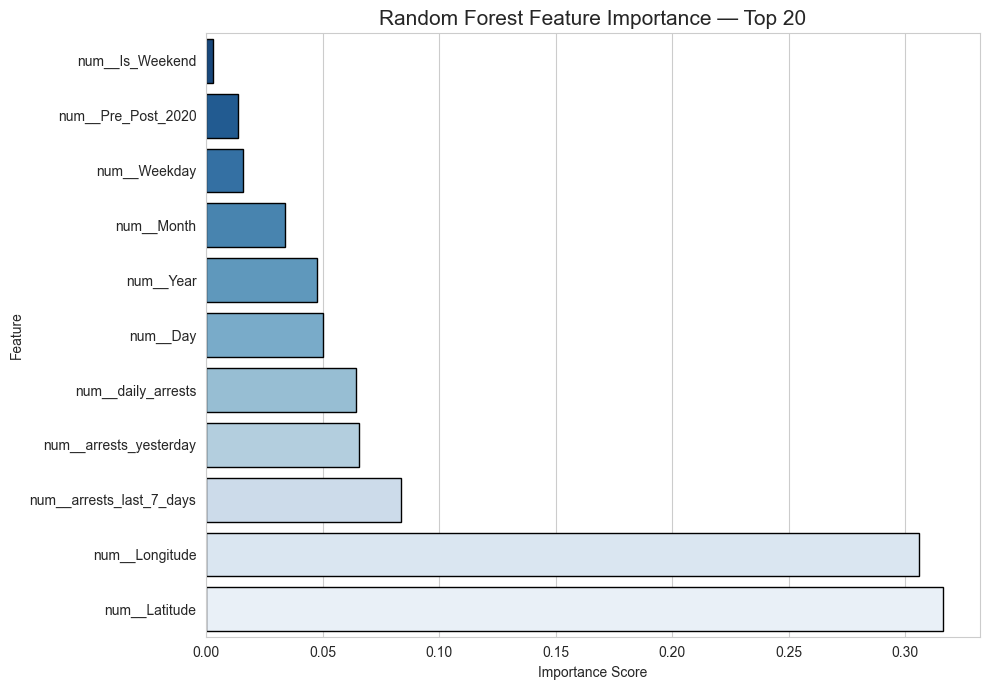

In [ ]:
#random forest
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap

from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


numeric_features = [
    'Year', 'Month', 'Day', 'Weekday', 'Is_Weekend', 'Pre_Post_2020',
    'Latitude', 'Longitude',
    'daily_arrests', 'arrests_yesterday', 'arrests_last_7_days'
]

numeric_features = [c for c in numeric_features if c in X_train.columns]

categorical_features = []

preprocess_ordinal = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features)
    ],
    remainder="drop"
)


rf_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess_ordinal),
        (
            "clf",
            RandomForestClassifier(
                n_estimators=300,
                max_depth=None,
                min_samples_split=20,
                min_samples_leaf=5,
                random_state=42,
                n_jobs=-1,
                class_weight="balanced_subsample"
            )
        ),
    ]
)


rf_pipeline.fit(X_train, y_train)

# Predict
y_pred_rf = rf_pipeline.predict(X_test)

print("\n================ RANDOM FOREST ================\n")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_rf, digits=4))


pre = rf_pipeline.named_steps["preprocess"]
rf_model = rf_pipeline.named_steps["clf"]

X_train_transformed = pre.transform(X_train)

# Sparse → dense
if hasattr(X_train_transformed, "toarray"):
    X_dense = X_train_transformed.toarray()
else:
    X_dense = X_train_transformed

# Feature names
try:
    feature_names = pre.get_feature_names_out()
except:
    feature_names = numeric_features

importances = rf_model.feature_importances_

imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
})

imp_top20 = imp_df.sort_values("importance", ascending=False).head(20)

plt.figure(figsize=(10, 7))
sns.barplot(
    data=imp_top20.sort_values("importance"),
    x="importance",
    y="feature",
    palette="Blues_r",
    edgecolor="black"
)
plt.title("Random Forest Feature Importance — Top 20", fontsize=15)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()





================ Linear SVM ================

SVM training on sampled subset: 150000 rows
Linear SVM - Accuracy: 0.6279943702206389

Classification Report (Linear SVM):

              precision    recall  f1-score   support

           0     0.7512    0.7058    0.7278    843638
           1     0.3865    0.4423    0.4126    353567

    accuracy                         0.6280   1197205
   macro avg     0.5689    0.5741    0.5702   1197205
weighted avg     0.6435    0.6280    0.6347   1197205



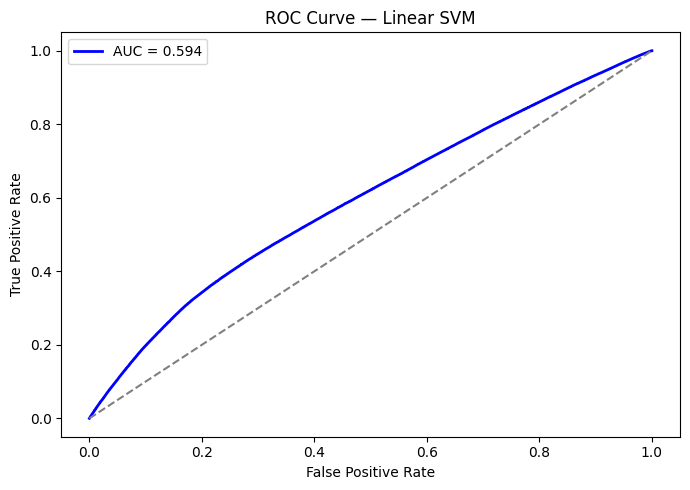

In [13]:
#linear SVM
from sklearn.model_selection import train_test_split

feature_columns = [
    'Year', 'Month', 'Day', 'Weekday', 'Is_Weekend', 'Pre_Post_2020',
    'Latitude', 'Longitude',
    'daily_arrests', 'arrests_yesterday', 'arrests_last_7_days'
]

X = df[feature_columns].copy()
y = df["felony_flag"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

numeric_features = [
    'Year', 'Month', 'Day', 'Weekday', 'Is_Weekend', 'Pre_Post_2020',
    'Latitude', 'Longitude',
    'daily_arrests', 'arrests_yesterday', 'arrests_last_7_days'
]

numeric_features = [c for c in numeric_features if c in X_train.columns]

preprocess_svm = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features)
    ],
    remainder="drop",
)

print("\n================ Linear SVM ================\n")

MAX_SVM_SAMPLES = 150000
X_train_svm = X_train.copy()
y_train_svm = y_train.copy()

# Sample for speed
if len(X_train_svm) > MAX_SVM_SAMPLES:
    X_train_svm, _, y_train_svm, _ = train_test_split(
        X_train_svm,
        y_train_svm,
        train_size=MAX_SVM_SAMPLES,
        stratify=y_train_svm,
        random_state=RANDOM_STATE,
    )
    print(f"SVM training on sampled subset: {len(X_train_svm)} rows")

# NEW PIPELINE (clean)
svm_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess_svm),
        (
            "clf",
            LinearSVC(
                C=1.0,
                class_weight="balanced",
                random_state=RANDOM_STATE,
            ),
        ),
    ]
)

svm_pipeline.fit(X_train_svm, y_train_svm)
y_pred_svm = svm_pipeline.predict(X_test)

print("Linear SVM - Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nClassification Report (Linear SVM):\n")
print(classification_report(y_test, y_pred_svm, digits=4))

from sklearn.metrics import roc_curve, auc

svm_scores = svm_pipeline.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, svm_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, linewidth=2, label=f"AUC = {roc_auc:.3f}", color="blue")
plt.plot([0,1],[0,1],"--",color="gray")
plt.title("ROC Curve — Linear SVM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()



/var/folders/4l/ps8gtn856617_4nt7nzqdfm80000gn/T/ipykernel_36995/274603287.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


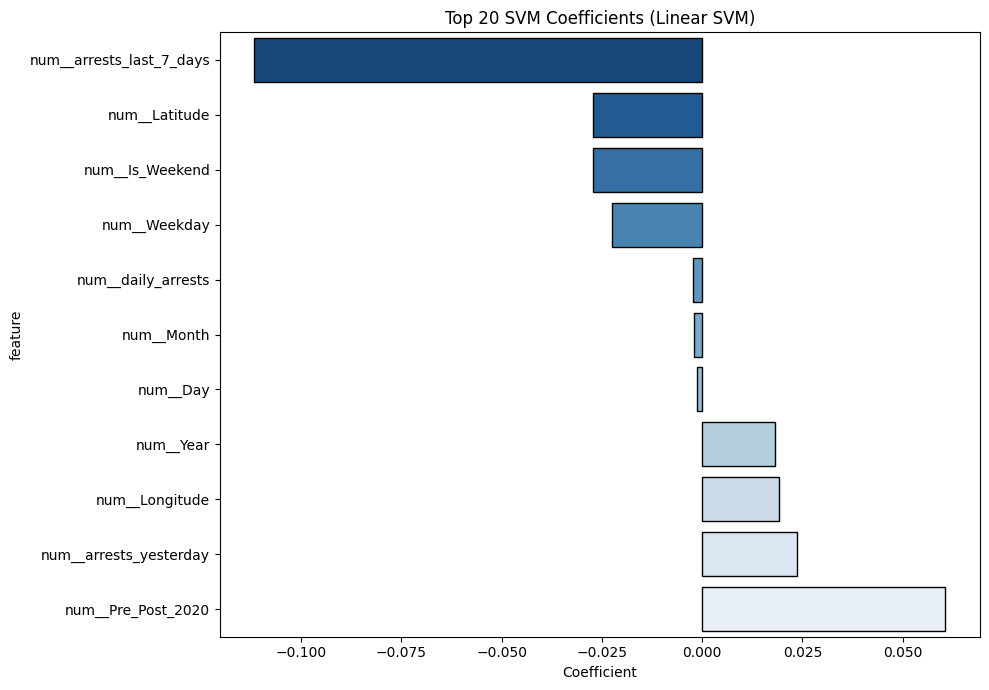

In [15]:
# Extract coefficients
svm_clf = svm_pipeline.named_steps["clf"]

coef = svm_clf.coef_.flatten()
features = preprocess_svm.get_feature_names_out()

coef_df = pd.DataFrame({"feature": features, "coef": coef})
coef_df = coef_df.reindex(coef_df.coef.abs().sort_values(ascending=False).index)

top20 = coef_df.head(20)

plt.figure(figsize=(10,7))
sns.barplot(
    data=top20.sort_values("coef"),
    x="coef",
    y="feature",
    palette="Blues_r",
    edgecolor="black"
)
plt.title("Top 20 SVM Coefficients (Linear SVM)")
plt.xlabel("Coefficient")
plt.tight_layout()
plt.show()


<Figure size 600x600 with 0 Axes>

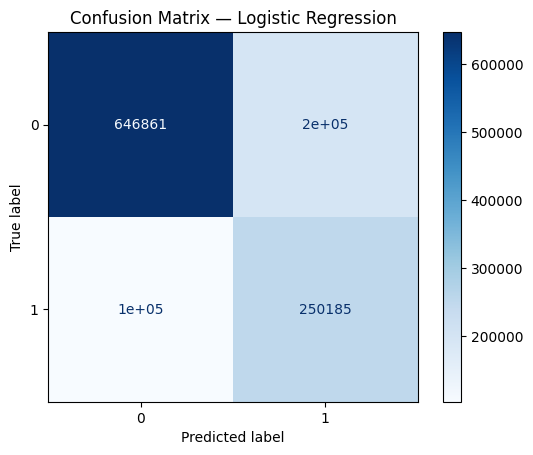

<Figure size 600x600 with 0 Axes>

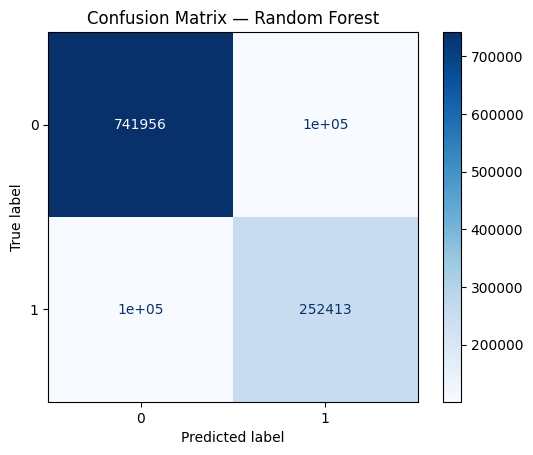

<Figure size 600x600 with 0 Axes>

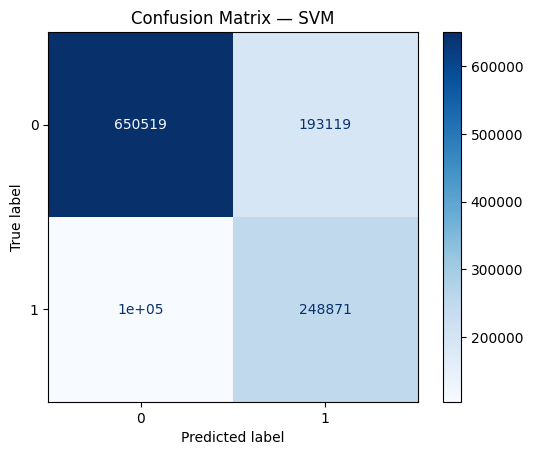

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_cm(y_true, y_pred, title):
    plt.figure(figsize=(6, 6))
    
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    
    disp.plot(cmap="Blues")
    plt.title(title)
    plt.show()
    

# Logistic Regression
plot_cm(y_test, y_pred_lr, "Confusion Matrix — Logistic Regression")

# Random Forest
plot_cm(y_test, y_pred_rf, "Confusion Matrix — Random Forest")

# SVM
plot_cm(y_test, y_pred_svm, "Confusion Matrix — SVM")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# ------------------------------------------------------
# 1. Sample and reset index correctly
# ------------------------------------------------------
basket_df = (
    df[['basket_str']]
    .dropna()
    .sample(500, random_state=42)
    .reset_index(drop=True)
)

# ------------------------------------------------------
# 2. Vectorize for cosine similarity
# ------------------------------------------------------
vectorizer = CountVectorizer(
    tokenizer=lambda s: s.split(','), 
    binary=True
)
basket_matrix = vectorizer.fit_transform(basket_df["basket_str"])

# ------------------------------------------------------
# 3. Choose the reference basket
# ------------------------------------------------------
ref_idx = 0
ref_vec = basket_matrix[ref_idx]

# Cosine similarity
cos_scores = cosine_similarity(ref_vec, basket_matrix).flatten()

# ------------------------------------------------------
# 4. Jaccard similarity function
# ------------------------------------------------------
def jaccard(a, b):
    set_a, set_b = set(a.split(',')), set(b.split(','))
    return len(set_a & set_b) / len(set_a | set_b) if set_a | set_b else 1.0

# ------------------------------------------------------
# 5. Build similarity table
# ------------------------------------------------------
similarity_table = pd.DataFrame({
    "basket_str": basket_df["basket_str"],
    "cosine_similarity": cos_scores
})

similarity_table["jaccard_similarity"] = similarity_table.index.map(
    lambda i: jaccard(basket_df.loc[ref_idx, "basket_str"], basket_df.loc[i, "basket_str"])
)

# ------------------------------------------------------
# 6. Remove the reference row
# ------------------------------------------------------
similarity_table = similarity_table.drop(index=ref_idx)

# ------------------------------------------------------
# 7. Sort and show top 10 similar baskets
# ------------------------------------------------------
similarity_table = similarity_table.sort_values(
    by="cosine_similarity",
    ascending=False
).head(10)

similarity_table


/Users/aashshah/Documents/coding/nyc_crime/.venv/lib/python3.14/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,basket_str,cosine_similarity,jaccard_similarity
177,"OFF_THEFT,BORO_M,PREC_17,AGE_25-44,SEX_M,RACE_...",0.625000,0.454545
398,"OFF_THEFT,BORO_M,PREC_10,AGE_25-44,SEX_M,RACE_...",0.625000,0.454545
304,"OFF_FRAUD,BORO_M,PREC_5,AGE_25-44,SEX_M,RACE_W...",0.589256,0.416667
104,"OFF_DRUG,BORO_M,PREC_18,AGE_25-44,SEX_M,RACE_A...",0.500000,0.333333
108,"OFF_DRUG,BORO_M,PREC_25,AGE_25-44,SEX_M,RACE_W...",0.500000,0.333333
221,"OFF_OTHER_STATE_LAWS_(NON_PENAL_LAW),BORO_M,PR...",0.500000,0.333333
335,"OFF_DRUG,BORO_M,PREC_33,AGE_25-44,SEX_M,RACE_W...",0.500000,0.333333
299,"OFF_POSSESSION_OF_STOLEN_PROPERTY_5,BORO_Q,PRE...",0.500000,0.333333
295,"OFF_THEFT,BORO_Q,PREC_112,AGE_25-44,SEX_M,RACE...",0.500000,0.333333
291,"OFF_THEFT,BORO_M,PREC_14,AGE_25-44,SEX_M,RACE_...",0.500000,0.333333


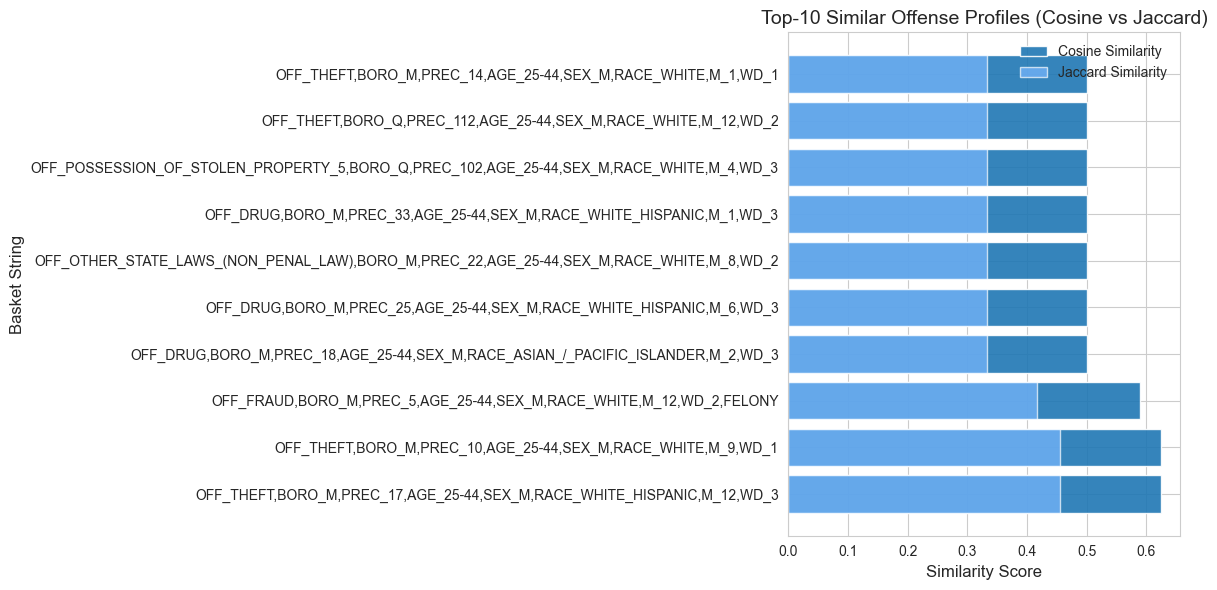

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure the table is sorted by cosine similarity already
sim_df = similarity_table.copy()

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Create the plot — cosine on left, jaccard on right as light overlay
plt.barh(
    sim_df["basket_str"],
    sim_df["cosine_similarity"],
    color="#1f77b4",
    alpha=0.9,
    label="Cosine Similarity",
)

plt.barh(
    sim_df["basket_str"],
    sim_df["jaccard_similarity"],
    color="#7ab8ff",
    alpha=0.7,
    label="Jaccard Similarity",
)

plt.xlabel("Similarity Score", fontsize=12)
plt.ylabel("Basket String", fontsize=12)
plt.title("Top-10 Similar Offense Profiles (Cosine vs Jaccard)", fontsize=14)
plt.legend(frameon=False)
plt.tight_layout()

plt.show()


In [ ]:
table_df = similarity_table[[
    "basket_str",
    "cosine_similarity",
    "jaccard_similarity"
]]

# Round values for cleaner display
table_df_display = table_df.copy()
table_df_display["cosine_similarity"] = table_df_display["cosine_similarity"].round(3)
table_df_display["jaccard_similarity"] = table_df_display["jaccard_similarity"].round(3)

table_df_display


,basket_str,cosine_similarity,jaccard_similarity
177,"OFF_THEFT,BORO_M,PREC_17,AGE_25-44,SEX_M,RACE_...",0.625,0.455
398,"OFF_THEFT,BORO_M,PREC_10,AGE_25-44,SEX_M,RACE_...",0.625,0.455
304,"OFF_FRAUD,BORO_M,PREC_5,AGE_25-44,SEX_M,RACE_W...",0.589,0.417
104,"OFF_DRUG,BORO_M,PREC_18,AGE_25-44,SEX_M,RACE_A...",0.500,0.333
108,"OFF_DRUG,BORO_M,PREC_25,AGE_25-44,SEX_M,RACE_W...",0.500,0.333
221,"OFF_OTHER_STATE_LAWS_(NON_PENAL_LAW),BORO_M,PR...",0.500,0.333
335,"OFF_DRUG,BORO_M,PREC_33,AGE_25-44,SEX_M,RACE_W...",0.500,0.333
299,"OFF_POSSESSION_OF_STOLEN_PROPERTY_5,BORO_Q,PRE...",0.500,0.333
295,"OFF_THEFT,BORO_Q,PREC_112,AGE_25-44,SEX_M,RACE...",0.500,0.333
291,"OFF_THEFT,BORO_M,PREC_14,AGE_25-44,SEX_M,RACE_...",0.500,0.333


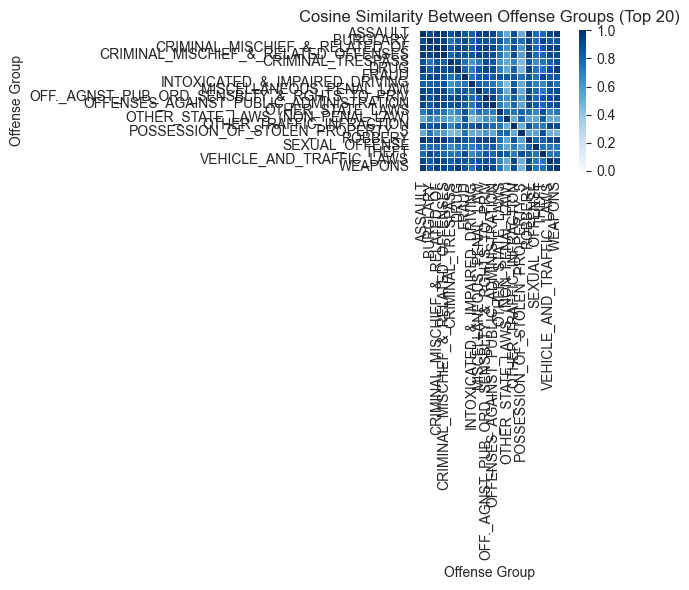

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

# ---- build offense_group × precinct matrix (counts) ----
top_offenses = df["offense_group"].value_counts().head(20).index
df_off = df[df["offense_group"].isin(top_offenses)].copy()

off_prec_pivot = (
    df_off
    .pivot_table(index="offense_group",
                 columns="ARREST_PRECINCT",
                 values="ARREST_KEY",
                 aggfunc="size",
                 fill_value=0)
)

# ---- cosine similarity between offense groups ----
cos_mat = cosine_similarity(off_prec_pivot.values)
cos_df = pd.DataFrame(
    cos_mat,
    index=off_prec_pivot.index,
    columns=off_prec_pivot.index
)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cos_df,
    cmap="Blues",
    vmin=0, vmax=1,
    square=True,
    linewidths=0.5,
    linecolor="white"
)
plt.title("Cosine Similarity Between Offense Groups (Top 20)")
plt.xlabel("Offense Group")
plt.ylabel("Offense Group")
plt.tight_layout()
plt.show()


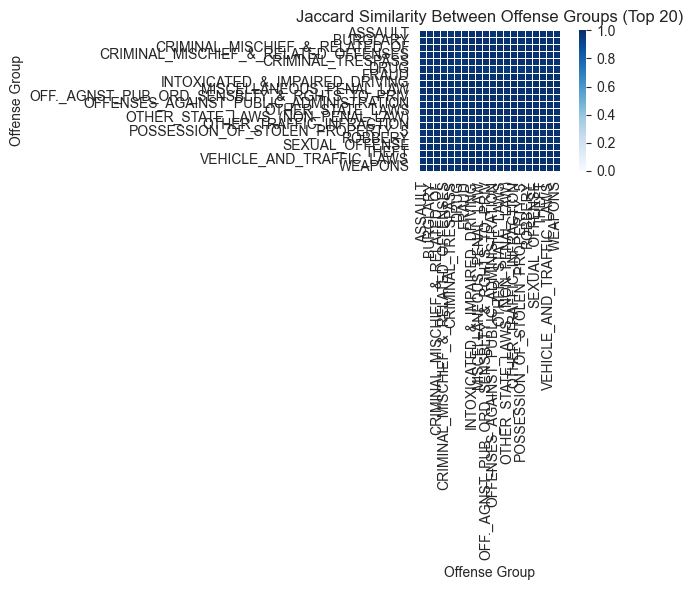

In [ ]:
import numpy as np

# binary presence of offense in each precinct
binary_mat = (off_prec_pivot > 0).astype(int).values
n = binary_mat.shape[0]

jacc_mat = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        inter = np.logical_and(binary_mat[i], binary_mat[j]).sum()
        union = np.logical_or(binary_mat[i], binary_mat[j]).sum()
        jacc_mat[i, j] = inter / union if union > 0 else 0.0

jacc_df = pd.DataFrame(
    jacc_mat,
    index=off_prec_pivot.index,
    columns=off_prec_pivot.index
)

plt.figure(figsize=(8, 6))
sns.heatmap(
    jacc_df,
    cmap="Blues",
    vmin=0, vmax=1,
    square=True,
    linewidths=0.5,
    linecolor="white"
)
plt.title("Jaccard Similarity Between Offense Groups (Top 20)")
plt.xlabel("Offense Group")
plt.ylabel("Offense Group")
plt.tight_layout()
plt.show()


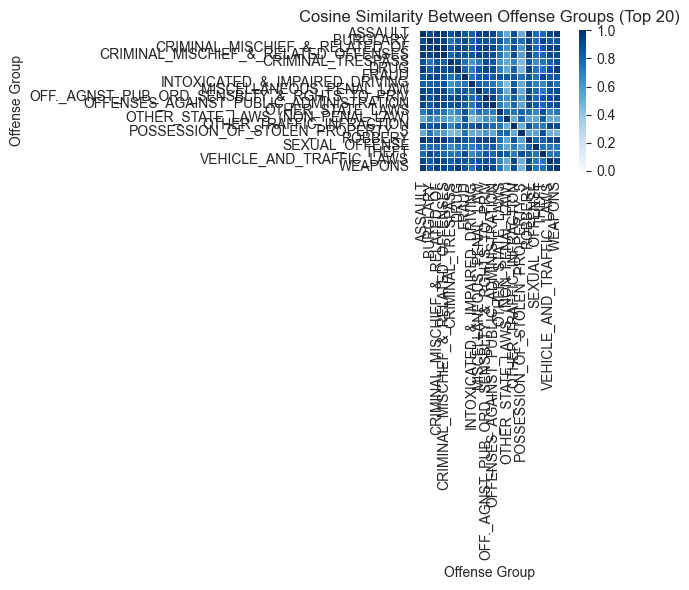

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

# ---- build offense_group × precinct matrix (counts) ----
top_offenses = df["offense_group"].value_counts().head(20).index
df_off = df[df["offense_group"].isin(top_offenses)].copy()

off_prec_pivot = (
    df_off
    .pivot_table(index="offense_group",
                 columns="ARREST_PRECINCT",
                 values="ARREST_KEY",
                 aggfunc="size",
                 fill_value=0)
)

# ---- cosine similarity between offense groups ----
cos_mat = cosine_similarity(off_prec_pivot.values)
cos_df = pd.DataFrame(
    cos_mat,
    index=off_prec_pivot.index,
    columns=off_prec_pivot.index
)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cos_df,
    cmap="Blues",
    vmin=0, vmax=1,
    square=True,
    linewidths=0.5,
    linecolor="white"
)
plt.title("Cosine Similarity Between Offense Groups (Top 20)")
plt.xlabel("Offense Group")
plt.ylabel("Offense Group")
plt.tight_layout()
plt.show()



================ Dimensional Reduction (PCA) ================

Numeric-only shape for PCA: (5986025, 11)
PCA explained variance ratio (2 components): [0.33763138 0.16919444]
PCA cumulative explained variance: 0.5068258270236947


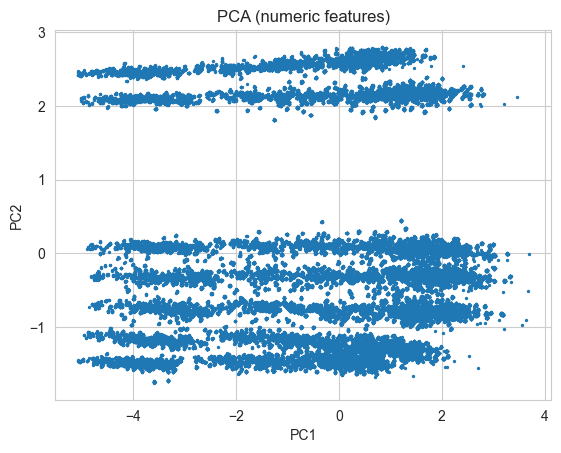

In [ ]:
#dimensionality reduction


print("\n================ Dimensional Reduction (PCA) ================\n")

if numeric_features:
    pca_df = df[numeric_features].dropna()
    print("Numeric-only shape for PCA:", pca_df.shape)

    # Sample if huge
    MAX_PCA_ROWS = 100000
    if len(pca_df) > MAX_PCA_ROWS:
        pca_df = pca_df.sample(MAX_PCA_ROWS, random_state=RANDOM_STATE)

    scaler_pca = StandardScaler()
    X_num_scaled = scaler_pca.fit_transform(pca_df)

    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    X_pca = pca.fit_transform(X_num_scaled)

    print("PCA explained variance ratio (2 components):", pca.explained_variance_ratio_)
    print("PCA cumulative explained variance:", pca.explained_variance_ratio_.sum())

    # If you want to plot later:
    import matplotlib.pyplot as plt
    plt.scatter(X_pca[:, 0], X_pca[:, 1], s=2)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("PCA (numeric features)")
    plt.show()

else:
    print("No numeric_features available for PCA. Skipping dimensionality reduction.")

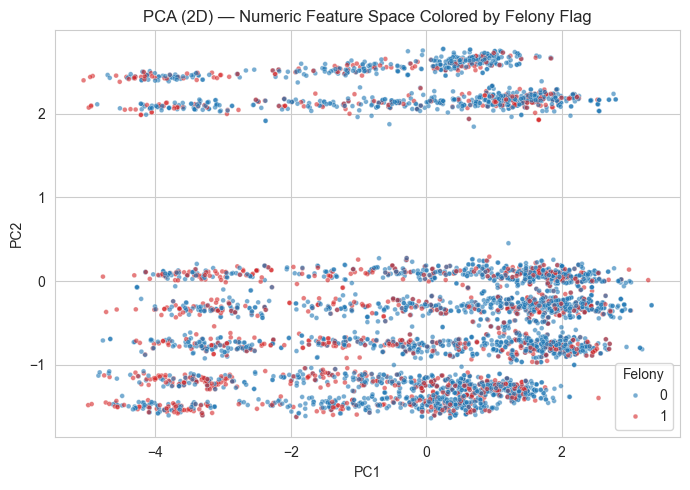

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# numeric columns actually present
num_cols = [
    'Year', 'Month', 'Day', 'Weekday', 'Is_Weekend', 'Pre_Post_2020',
    'Latitude', 'Longitude',
    'daily_arrests', 'arrests_yesterday', 'arrests_last_7_days'
]
num_cols = [c for c in num_cols if c in df.columns]

X_num = df[num_cols].dropna()
y_pca = df.loc[X_num.index, "felony_flag"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "felony_flag": y_pca.values
})

plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=pca_df.sample(min(5000, len(pca_df)), random_state=42),
    x="PC1", y="PC2",
    hue="felony_flag",
    palette={0: "#1f77b4", 1: "#d62728"},
    alpha=0.6,
    s=12
)
plt.title("PCA (2D) — Numeric Feature Space Colored by Felony Flag")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Felony", loc="best")
plt.tight_layout()
plt.show()


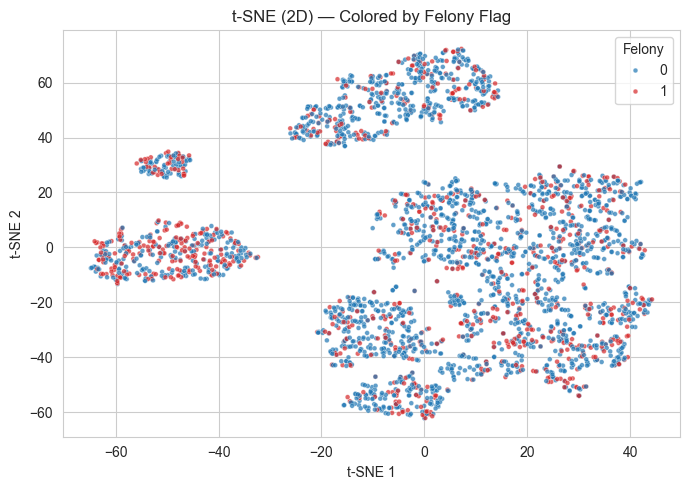

In [ ]:
from sklearn.manifold import TSNE

# sample for speed
tsne_sample = pca_df.sample(min(3000, len(pca_df)), random_state=42)
X_tsne_in = X_scaled[tsne_sample.index]

tsne = TSNE(
    n_components=2,
    random_state=42,
    perplexity=30,
    learning_rate='auto',
    init="pca"
)
X_tsne = tsne.fit_transform(X_tsne_in)

tsne_df = pd.DataFrame({
    "TSNE1": X_tsne[:, 0],
    "TSNE2": X_tsne[:, 1],
    "felony_flag": tsne_sample["felony_flag"].values
})

plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=tsne_df,
    x="TSNE1", y="TSNE2",
    hue="felony_flag",
    palette={0: "#1f77b4", 1: "#d62728"},
    alpha=0.7,
    s=12
)
plt.title("t-SNE (2D) — Colored by Felony Flag")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Felony", loc="best")
plt.tight_layout()
plt.show()


In [19]:
import pandas as pd

# --- MODEL PERFORMANCE FROM YOUR RESULTS ---
model_results = {
    "Model": [
        "Random Forest",
        "Decision Tree",
        "MLP Classifier",
        "Linear SVM",
        "Logistic Regression",
        "KNN (k=9)",
        "Naive Bayes"
    ],
    "Accuracy": [
        0.8306,
        0.78,
        0.78,
        0.7512,
        0.7493,
        0.749,
        0.75
    ],
    "Precision (Class 1)": [
        0.7128,
        0.55,
        0.58,
        0.5631,
        0.5597,
        0.63,
        0.40
    ],
    "Recall (Class 1)": [
        0.7139,
        0.45,
        0.52,
        0.7039,
        0.7076,
        0.32,
        0.20
    ],
    "F1 Score (Class 1)": [
        0.7134,
        0.49,
        0.55,
        0.6257,
        0.6250,
        0.43,
        0.27
    ]
}

df_compare = pd.DataFrame(model_results)

# 🔥 Sort by Accuracy descending
df_compare_sorted = df_compare.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

df_compare_sorted


,Model,Accuracy,Precision (Class 1),Recall (Class 1),F1 Score (Class 1)
0,Random Forest,0.8306,0.7128,0.7139,0.7134
1,Decision Tree,0.7800,0.5500,0.4500,0.4900
2,MLP Classifier,0.7800,0.5800,0.5200,0.5500
3,Linear SVM,0.7512,0.5631,0.7039,0.6257
4,Naive Bayes,0.7500,0.4000,0.2000,0.2700
5,Logistic Regression,0.7493,0.5597,0.7076,0.6250
6,KNN (k=9),0.7490,0.6300,0.3200,0.4300


/var/folders/4l/ps8gtn856617_4nt7nzqdfm80000gn/T/ipykernel_36995/1538774638.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Accuracy", data=df_models, palette="Blues_r")


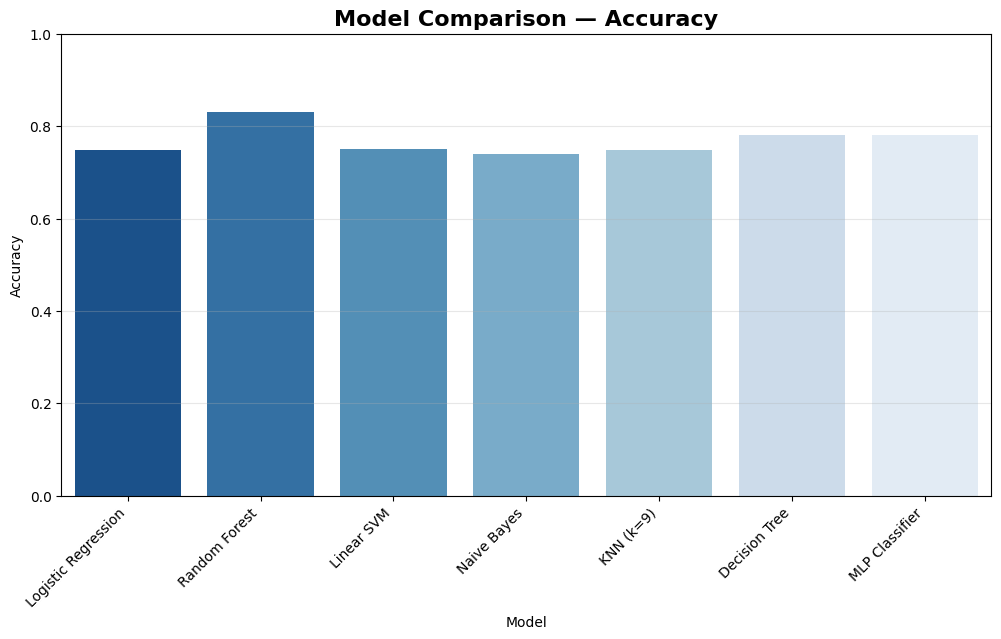

/var/folders/4l/ps8gtn856617_4nt7nzqdfm80000gn/T/ipykernel_36995/1538774638.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="F1_Felony", data=df_models, palette="Reds_r")


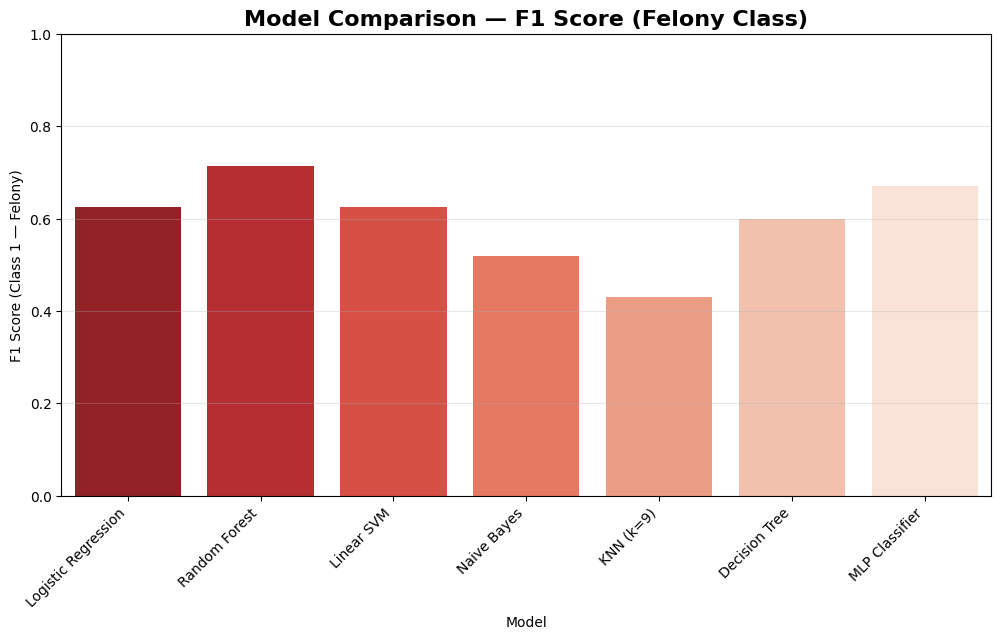


===== MODEL INSIGHTS (Copy to Slide) =====

Logistic Regression:
  Accuracy: 0.749
  F1 (Felony): 0.625

Random Forest:
  Accuracy: 0.831
  F1 (Felony): 0.713

Linear SVM:
  Accuracy: 0.751
  F1 (Felony): 0.626

Naive Bayes:
  Accuracy: 0.740
  F1 (Felony): 0.520

KNN (k=9):
  Accuracy: 0.749
  F1 (Felony): 0.430

Decision Tree:
  Accuracy: 0.780
  F1 (Felony): 0.600

MLP Classifier:
  Accuracy: 0.780
  F1 (Felony): 0.670



In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


df_models = pd.DataFrame({
    "Model": [
        "Logistic Regression",
        "Random Forest",
        "Linear SVM",
        "Naive Bayes",
        "KNN (k=9)",
        "Decision Tree",
        "MLP Classifier"
    ],
    "Accuracy": [
        0.7493,
        0.8306,
        0.7512,
        0.74,      
        0.749,     
        0.78,      
        0.78       
    ],
    "F1_Felony": [
        0.6250,
        0.7134,
        0.6257,
        0.52,    
        0.43,    
        0.60,    
        0.67     
    ]
})

plt.figure(figsize=(12,6))
sns.barplot(x="Model", y="Accuracy", data=df_models, palette="Blues_r")
plt.title("Model Comparison — Accuracy", fontsize=16, weight='bold')
plt.ylabel("Accuracy")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.show()



plt.figure(figsize=(12,6))
sns.barplot(x="Model", y="F1_Felony", data=df_models, palette="Reds_r")
plt.title("Model Comparison — F1 Score (Felony Class)", fontsize=16, weight='bold')
plt.ylabel("F1 Score (Class 1 — Felony)")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.show()


print("\n===== MODEL INSIGHTS (Copy to Slide) =====\n")

for idx, row in df_models.iterrows():
    print(f"{row['Model']}:")
    print(f"  Accuracy: {row['Accuracy']:.3f}")
    print(f"  F1 (Felony): {row['F1_Felony']:.3f}")
    print()


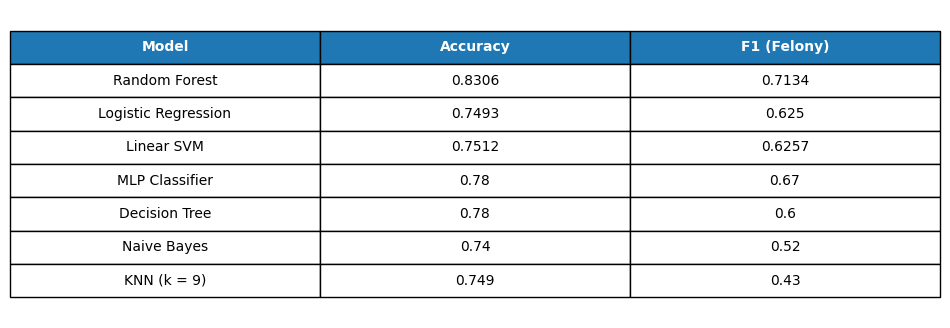

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


data = {
    "Model": [
        "Random Forest","Logistic Regression","Linear SVM",
        "MLP Classifier","Decision Tree","Naive Bayes","KNN (k = 9)"
    ],
    "Accuracy": [0.8306, 0.7493, 0.7512, 0.78, 0.78, 0.74, 0.7490],
    "F1 (Felony)": [0.7134, 0.6250, 0.6257, 0.67, 0.60, 0.52, 0.43],
    "Main Strength": [
        "Best overall; captures non-linear patterns & interactions",
        "Simple, fast, and highly interpretable coefficients",
        "Good margin-based classifier in high-dim space",
        "Learns non-linear structure; flexible architecture",
        "Very interpretable, clear IF–THEN rules",
        "Extremely fast; good sanity-check baseline",
        "Intuitive 'similar cases' perspective"
    ],
    "Main Limitation": [
        "Heavier compute; less interpretable than linear models",
        "Limited by linear decision boundary",
        "Still linear; struggles with complex manifolds",
        "Needs tuning; gains are modest over Random Forest",
        "Prone to overfitting; unstable to data changes",
        "Strong independence assumptions → weak felony F1",
        "Suffers from high-dimensional sparsity; low felony recall"
    ]
}

df_comp = pd.DataFrame(data)

plt.figure(figsize=(12, 4))
plt.axis('off')

table = plt.table(
    cellText=df_comp[["Model","Accuracy","F1 (Felony)"]].values,
    colLabels=["Model","Accuracy","F1 (Felony)"],
    cellLoc="center",
    loc="center"
)

# Formatting: blue header + clean white cells
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_facecolor("#1f77b4")
        cell.set_text_props(color="white", weight="bold")
    else:
        cell.set_facecolor("white")

table.scale(1, 2)

plt.show()
